# Uitwerkingen H7: 7.49

In [1813]:
import math
import numpy as np
import matplotlib.pyplot as plt 

In [1814]:
puntlasten = np.array([[]])  # [position (m), magnitude (kN)]
koppel = np.array([[]])  # [position (m), magnitude (kNm)]
verdeeldeBelasting = np.array([[]])  # [start position (m), end position (m), magnitude (kN/m)]

lengteBalk = 6    # lengte van de balk [m]
A = 0         # positie oplegging A (rol) [m]
B = 4        # positie oplegging B (scharnier) [m]

#puntlasten = np.array([ [3, 0, -50] ])  # [position (m), magnitude (kN)]
#koppel = np.array([[3, 50]])  # [position (m), magnitude (kNm)]
verdeeldeBelasting = np.array([[0, 6, -8]])  # [start position (m), end position (m), magnitude (kN/m)]

divs = 10000  # aantal deelstukken voor de balk
dx = lengteBalk / divs  # lengte van een deelstuk [m]
X = np.arange(0, lengteBalk + 2*dx, dx)  # x-coordinaten van de deelstukken [m]
nPL = len(puntlasten[0])  # aantal puntlasten
nPM = len(koppel[0])  # aantal puntmomenten
nVB = len(verdeeldeBelasting[0])  # aantal verdeelde lasten

reactieKrachten = np.array([0,0,0])  # [Va (kN), Ha (kN), Vb (kN)]
shearForce = np.empty([0,len(X)])  # schuifkracht langs de balk [kN]
bendingMoment = np.empty([0,len(X)])  # buigend moment langs de balk [k


In [1815]:
def reactie_PL(n):
    xp = puntlasten[n,0]
    fx = puntlasten[n,1]
    fy = puntlasten[n,2]

    la_p = A - xp
    mp = fy * la_p
    la_vb = B - A

    Vb = mp / la_vb
    Va = -fy - Vb
    Ha = -fx

    return Va, Vb, Ha

def reactie_PM(n):
    xm = koppel[n,0]
    m = koppel[n,1]

    la_vb = B - A

    Vb = m / la_vb
    Va = - Vb

    return Va, Vb

def reactie_VB(n):
    xStart = verdeeldeBelasting[n,0]
    xEnd = verdeeldeBelasting[n,1]
    fy = verdeeldeBelasting[n,2]

    fy_Res = fy * (xEnd - xStart)  # resulterende kracht van de UDL
    x_Res = xStart + 0.5 * (xEnd - xStart)  # positie van de resulterende kracht van de UDL    

    la_p = A - x_Res
    mp = fy_Res * la_p
    la_vb = B - A

    Vb = mp / la_vb
    Va = - fy_Res - Vb

    return Va, Vb

In [1816]:
PL_record = np.empty([0,3])  # [Va (kN), Vb (kN), Ha (kN)]
if (nPL > 0):

    for n, p in enumerate(puntlasten):
        va, vb, ha = reactie_PL(n)
        PL_record = np.append(PL_record, [np.array([va, ha, vb])], axis=0)

        reactieKrachten[0] += va
        reactieKrachten[1] += ha
        reactieKrachten[2] += vb

PM_record = np.empty([0,2])  # [Va (kN), Vb (kN), Ha (kN)]
if (nPM > 0):
    for n, p in enumerate(koppel):
        va, vb = reactie_PM(n)
        PM_record = np.append(PM_record, [np.array([va, vb])], axis=0)

        reactieKrachten[0] += va
        #reactieKrachten[1] += ha
        reactieKrachten[2] += vb

VB_record = np.empty([0,2])  # [Va (kN), Vb (kN), Ha (kN)]
if (nVB > 0):
    for n, p in enumerate(verdeeldeBelasting):
        va, vb = reactie_VB(n)
        VB_record = np.append(VB_record, [np.array([va, vb])], axis=0)

        reactieKrachten[0] += va
        #reactieKrachten[1] += ha
        reactieKrachten[2] += vb

In [1817]:
def shear_moment_PL(n):
    xp = puntlasten[n,0]
    #fx = puntlasten[n,1]
    fy = puntlasten[n,2]
    Va = PL_record[n,0]
    Vb = PL_record[n,2]

    Shear = np.zeros(len(X))
    Moment = np.zeros(len(X))

    for i, x in enumerate(X):
        shear = 0
        moment = 0

        if x > A:
            shear = shear + Va
            moment = moment + Va * (x - A)

        if x > xp:
            shear = shear + fy
            moment = moment + fy * (x - xp)

        if x > B:
            shear = shear + Vb
            moment = moment + Vb * (x - B)

        Shear[i] = shear
        Moment[i] = moment

    return Shear, Moment

def shear_moment_PM(n):
    xm = koppel[n,0]
    m = koppel[n,1]
    Va = PM_record[n,0]
    Vb = PM_record[n,1]

    Shear = np.zeros(len(X))
    Moment = np.zeros(len(X))

    for i, x in enumerate(X):
        shear = 0
        moment = 0

        if x > A:
            shear = shear + Va
            moment = moment + Va * (x - A)

        if x > xm:
            moment = moment + m

        if x > B:
            shear = shear + Vb
            moment = moment + Vb * (x - B)

        Shear[i] = shear
        Moment[i] = moment

    return Shear, Moment

def shear_moment_UDL(n):
    xStart = verdeeldeBelasting[n,0]
    xEnd = verdeeldeBelasting[n,1]
    fy = verdeeldeBelasting[n,2]
    Va = VB_record[n,0]
    Vb = VB_record[n,1]

    Shear = np.zeros(len(X))
    Moment = np.zeros(len(X))

    for i, x in enumerate(X):
        shear = 0
        moment = 0

        if x > A:
            shear = shear + Va
            moment = moment + Va * (x - A)

        if x > B:
            shear = shear + Vb
            moment = moment + Vb * (x - B)
        
        if x > xStart and x <= xEnd :
            shear = shear + fy * (x - xStart)
            moment = moment + fy * (x - xStart) * 0.5 * (x - xStart)
        elif( x > xEnd ):
            shear = shear + fy * (xEnd - xStart)
            moment = moment + fy * (xEnd - xStart) * (x-xStart - 0.5 * (xEnd - xStart))



        Shear[i] = shear
        Moment[i] = moment

    return Shear, Moment

In [1818]:
if (nPL > 0):
    for n, p in enumerate(puntlasten):
        Shear, Moment = shear_moment_PL(n)
        shearForce = np.append(shearForce, [Shear], axis=0)
        bendingMoment = np.append(bendingMoment, [Moment], axis=0)

if (nPM > 0):
    for n, p in enumerate(koppel):
        Shear, Moment = shear_moment_PM(n)
        shearForce = np.append(shearForce, [Shear], axis=0)
        bendingMoment = np.append(bendingMoment, [Moment], axis=0)

if (nVB > 0):
    for n, p in enumerate(verdeeldeBelasting):
        Shear, Moment = shear_moment_UDL(n)
        shearForce = np.append(shearForce, [Shear], axis=0)
        bendingMoment = np.append(bendingMoment, [Moment], axis=0)


In [1819]:
print ("De verticale reactiekrachten in A is {one} kN".format(one= round(reactieKrachten[0],2) ))
print ("De verticale reactiekrachten in B is {one} kN".format(one= round(reactieKrachten[2],2) ))

De verticale reactiekrachten in A is 12 kN
De verticale reactiekrachten in B is 36 kN


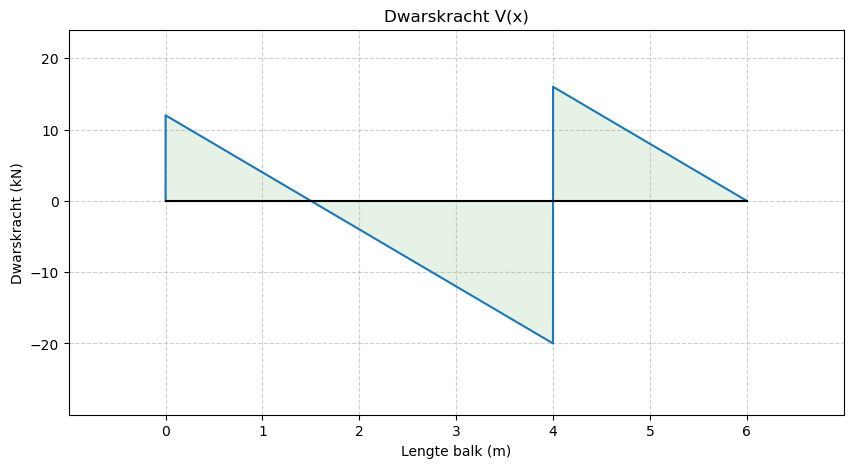

In [1820]:
import matplotlib.pyplot as plt
import numpy as np

# Maak een nieuwe figuur
plt.figure(figsize=(10, 5))

# Dwarsekrachtlijn tekenen
plt.plot(X, np.sum(shearForce, axis=0), label="Dwarskracht (kN)")

# Opvullen onder de lijn
plt.fill_between(X, np.sum(shearForce, axis=0), color='green', alpha=0.1)

# Horizontale as alleen van x = 0 tot x = lengteBalk
plt.plot([0, lengteBalk], [0, 0], color='black')


# Titels en labels
plt.title("Dwarskracht V(x)")
plt.xlabel("Lengte balk (m)")
plt.ylabel("Dwarskracht (kN)")

# x-as bereik zoals in Plotly
plt.xlim(-1, lengteBalk + 1)

# x-as bereik zoals in Plotly
plt.ylim(1.5*min(np.sum(shearForce, axis=0)), 1.5*max(np.sum(shearForce, axis=0)) )

# x-ticks op elke meter
plt.xticks(np.arange(0, lengteBalk + 1, 1))

# **Grid met stippellijnen**
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()


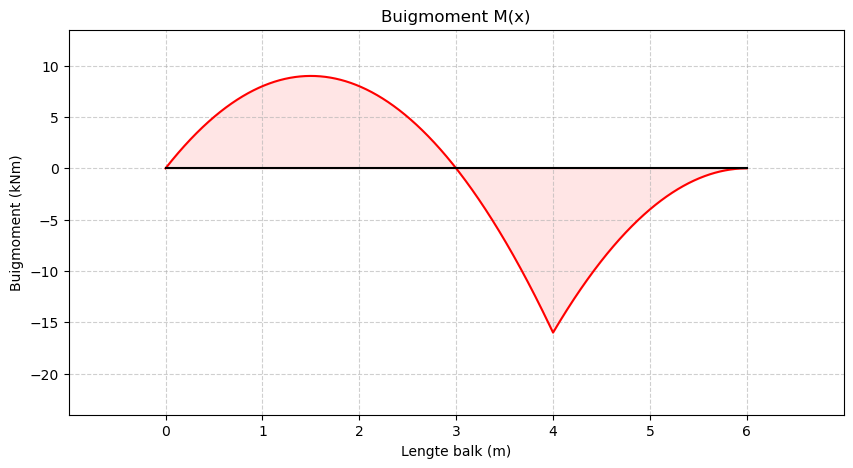

In [1821]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 5))

# Buigmomentlijn
plt.plot(X, np.sum(bendingMoment, axis=0), label="Buigmoment (kNm)", color='red')

# Opvullen onder de lijn
plt.fill_between(X, np.sum(bendingMoment, axis=0), color='red', alpha=0.1)

# Horizontale as alleen van 0 tot lengteBalk
plt.plot([0, lengteBalk], [0, 0], color='black')

# Titels en labels
plt.title("Buigmoment M(x)")
plt.xlabel("Lengte balk (m)")
plt.ylabel("Buigmoment (kNm)")

# Zelfde x-as bereik als Plotly
plt.xlim(-1, lengteBalk + 1)

plt.ylim(1.5*min(np.sum(bendingMoment, axis=0)), 1.5*max(np.sum(bendingMoment, axis=0)) )

# x-ticks op elke meter
plt.xticks(np.arange(0, lengteBalk + 1, 1))

# Grid met stippellijnen (consistent met vorige plot)
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()
